In [1]:
!pip install idx2numpy
import idx2numpy
from google.colab.patches import cv2_imshow
from PIL import Image
import random
import math
import pickle
import cv2 as cv
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import linear_model
from sklearn.model_selection import train_test_split

  Created wheel for idx2numpy: filename=idx2numpy-1.2.3-py3-none-any.whl size=7919 sha256=b83f1a4e1197f2e252fd69306ec2886d2aa89483655e589ae5b5dedb55f651dc
  Stored in directory: /root/.cache/pip/wheels/1a/ce/ad/d5e95a35cfe34149aade5e500f2edd535c0566d79e9a8e1d8a
Successfully built idx2numpy


In [2]:
# dataset import
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/ML

x_train = idx2numpy.convert_from_file('train-images.idx3-ubyte')
y_train = idx2numpy.convert_from_file('train-labels.idx1-ubyte')
x_test = idx2numpy.convert_from_file('t10k-images.idx3-ubyte')
y_test = idx2numpy.convert_from_file('t10k-labels.idx1-ubyte')

Mounted at /content/drive
/content/drive/MyDrive/ML


In [3]:
# size of dataset

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
# splitting data into test and train datasets
def split_train_test(input, output, train_ratio=0.8):
    x_train = []
    y_train = []
    x_test = input.tolist()
    y_test = output.tolist()
    train_size = math.floor(train_ratio * len(input))
    
    while len(x_train) < train_size:
        index = random.randint(0, len(x_test)-1)
        x_train.append(x_test.pop(index))
        y_train.append(y_test.pop(index))
    
    return x_train, x_test, y_train, y_test

# normalisation
def normalise(data):
    data = np.divide(data, 255)
    return data

# converting images to 1D arrays
train_num_samples, train_dim1, train_dim2 = x_train.shape
test_num_samples, test_dim1, test_dim2 = x_test.shape
x_train = x_train.reshape(train_num_samples, train_dim1*train_dim2)
x_test = x_test.reshape(test_num_samples, test_dim1*test_dim2)

# combining train and test data
x_train = np.concatenate((x_train, x_test), axis=0)
y_train = np.concatenate((y_train, y_test), axis=0)

# splitting into train, validation, test datasets
random.seed(0)
x_train, x_test, y_train, y_test = split_train_test(x_train, y_train, 0.9)
x_train, x_val, y_train, y_val = split_train_test(np.array(x_train), np.array(y_train), 0.77)

x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)
x_val = np.array(x_val)
y_val = np.array(y_val)

y_train = np.reshape(y_train, (y_train.shape[0], 1))
y_test = np.reshape(y_test, (y_test.shape[0], 1))
y_val = np.reshape(y_val, (y_val.shape[0], 1))
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape)

x_train = normalise(x_train)
x_val = normalise(x_val)

(48510, 784) (48510, 1) (7000, 784) (7000, 1) (14490, 784) (14490, 1)


In [12]:
class MyNeuralNetwork:
    def __init__(self, random_state=0, n_layers=4, layer_sizes=[256, 128, 64, 32], activation='sigmoid', learning_rate=0.08, weights_init='normal_init', batch_size=None, num_epochs=150):
        self.random_state = random_state
        self.n_layers = n_layers+2
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.weights_init = weights_init
        self.batch_size = batch_size
        self.accuracy = 0
        self.num_classes = 10
        self.weights = []
        self.bias = []
        self.v_val = []
        self.layers = []
        self.errors = []
        self.updates = []
        self.updates_b = []
        self.train_losses = []
        self.val_losses = []
        self.y_pred = []

    def fit(self, x_train, y_train, x_val=None, y_val=None):
        x_train = x_train.T
        y_train = y_train.T
        num_samples = x_train.shape[1]
        y_train = self.encoding(y_train)
        if y_val is not None:
            y_val = self.encoding(y_val)
        act_fn = getattr(self, self.activation)
        wt_init_fn = getattr(self, self.weights_init)
        self.weights = wt_init_fn(x_train.shape[0], self.num_classes)
        self.bias = self.bias_init(x_train.shape[0], self.num_classes)

        for i  in range(self.num_epochs):

            self.v_val = []
            self.layers = []
            self.errors = []
            self.updates = []
            self.updates_b = []
            # Forward Phase
            self.layers.append(x_train)
            for j in range(self.n_layers-1):
                layer = np.dot(self.weights[j].T, self.layers[j]) + self.bias[j]
                self.v_val.append(layer)
                self.layers.append(act_fn(layer))
            layer = np.dot(self.weights[j].T, self.layers[j]) + self.bias[j]
            prob = self.softmax(layer)
            self.v_val.append(layer)
            self.layers.append(prob)

            # Backward Phase
            train_loss = self.cross_entropy_loss(y_train, self.layers[-1])
            error = y_train-self.layers[-1]
            self.errors.append(error)
            update = error*self.softmax(self.layers[-1], deriv=True)/num_samples
            self.updates.append(update)
            update_b = np.sum(error, axis=1, keepdims=True)/num_samples
            self.updates_b.append(update_b)
            for j in reversed(range(self.n_layers-1)):
                error = np.dot(self.weights[j], update)
                self.errors.insert(0, error)
                update = error*act_fn(self.layers[j], deriv=True)/num_samples
                self.updates.insert(0, update)
                update_b = np.sum(error, axis=1, keepdims=True)/num_samples
                self.updates_b.insert(0, update_b)

            for j in range(self.n_layers-1):
                self.weights[j] += self.learning_rate*np.dot(self.layers[j], self.updates[j+1].T)
                self.bias[j] += self.learning_rate*self.updates_b[j+1]

            self.train_losses.append(np.mean(np.abs(train_loss)))

            if x_val is not None:
                val_prob = self.predict_proba(x_val)
                val_loss = self.cross_entropy_loss(y_val, val_prob)
                self.val_losses.append(np.mean(np.abs(val_loss)))

        self.accuracy = (1-self.train_losses[-1])*100

    def predict_proba(self, x):
        x = x.T
        act_fn = getattr(self, self.activation)
        predict_layers = []
        predict_layers.append(x)
        for i in range(self.n_layers-1):
            layer = np.dot(self.weights[i].T, predict_layers[i])
            predict_layers.append(act_fn(layer))
        layer = np.dot(self.weights[i].T, predict_layers[i])
        prob = self.softmax(layer)
        predict_layers.append(prob)
        return prob

    def predict(self, x):
        prob = self.predict_proba(x)
        num_samples = x.shape[0]
        self.y_pred = np.zeros(num_samples)
        for i in range(num_samples):
            self.y_pred[i] = np.argmax(prob[:, i])
        return self.y_pred

    def score(self, x, y):
        y_pred = self.predict(x)
        ctr = 0
        for i in range(len(y)):
            if y_pred[i] == y[i]:
                ctr += 1
        accuracy = ctr/len(y)
        return accuracy

    def cross_entropy_loss(self, y, y_prob):
        loss = - np.sum(y*np.log2(y_prob))
        return loss/y.shape[0]
    def encoding(self, y):
        num_samples = y.shape[0]
        encoded = np.zeros((self.num_classes, num_samples))
        for i in range(num_samples):
            encoded[y[i]][i] = 1
        return encoded

# activation functions
    def relu(self, x, deriv=False):
        if deriv == False:
            return np.maximum(0.0, x)
        else:
            return np.maximum(0.0, np.sign(x))
    def leaky_relu(self, x, deriv=False):
        if deriv == False:
            return np.maximum(0.01*x, x)
        else:
            return np.maximum(0.01, np.sign(x))
    def sigmoid(self, x, deriv=False):
        if deriv == False:
            return 1/(1 + np.exp(-x))
        else:
            return self.sigmoid(x)*(1 - self.sigmoid(x))
    def tanh(self, x, deriv=False):
        if deriv == False:
            return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
        else:
            return 1 - self.tanh(x)*self.tanh(x)
    def linear(self, x, deriv=False):
        if deriv == False:
            return x
        else:   
            return np.ones(x.shape)
    def softmax2(self, x, deriv=False):
        if deriv == False:
            return np.exp(x)/np.sum(np.exp(x))
        else:
            return self.softmax(x)*(1 - self.softmax(x))
    def softmax(self, x, deriv=False):
        if deriv == False:
            return np.exp(x)/np.sum(np.exp(x), axis = 1, keepdims=True)
        else:
            return self.softmax(x)*(1 - self.softmax(x))

# bias initialization
    def bias_init(self, inp, out):
        random.seed(self.random_state)
        bias = []
        for i in range(len(self.layer_sizes)):
            bias.append(np.zeros((self.layer_sizes[i], 1)))
        bias.append(np.zeros((out, 1)))
        return bias   

# weight initialisation 
    def zero_init(self, inp, out):
        random.seed(self.random_state)
        weights = []
        weights.append(np.zeros((inp, self.layer_sizes[0])))
        for i in range(len(self.layer_sizes)-1):
            weights.append(np.zeros((self.layesizes[i], self.layer_sizes[i+1])))
        weights.append(np.zeros((self.layer_sr_izes[-1], out)))
        return weights
    def random_init(self, inp, out):
        random.seed(self.random_state)
        weights = []
        weights.append(0.01*np.random.random((inp, self.layer_sizes[0])))
        for i in range(len(self.layer_sizes)-1):
            weights.append(0.01*np.random.random((self.layer_sizes[i], self.layer_sizes[i+1])))
        weights.append(0.01*np.random.random((self.layer_sizes[-1], out)))
        return weights
    def normal_init(self, inp, out):
        random.seed(self.random_state)
        weights = []
        weights.append(0.01*np.random.normal(0.0, 1.0, (inp, self.layer_sizes[0])))
        for i in range(len(self.layer_sizes)-1):
            weights.append(0.01*np.random.normal(0.0, 1.0, (self.layer_sizes[i], self.layer_sizes[i+1])))
        weights.append(0.01*np.random.normal(0.0, 1.0, (self.layer_sizes[-1], out)))
        return weights

In [13]:
# relu

mnn = MyNeuralNetwork(random_state=0, activation='relu', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=0.08)
mnn.fit(x_train, y_train.ravel(), x_val, y_val.ravel())
mnn.predict(x_test)
print('Test accuracy:', mnn.score(x_test, y_test))

Test accuracy: 0.09657142857142857


In [14]:
filename = 'relu'
pickle.dump(mnn, open(filename, 'wb'))
# loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mnn.train_losses, label='train loss')
if len(mnn.val_losses)>0:
    plt.plot(mnn.val_losses, label='val loss')
plt.title('ReLU')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Leaky ReLU**

In [37]:
# leaky relu

mnn = MyNeuralNetwork(random_state=0, activation='leaky_relu', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=0.08)
mnn.fit(x_train, y_train.ravel(), x_val, y_val.ravel())
mnn.predict(x_test)
print('Test accuracy:', mnn.score(x_test, y_test))

Test accuracy: 0.103


In [38]:
filename = 'Leaky_relu'
pickle.dump(mnn, open(filename, 'wb'))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mnn.train_losses, label='train loss')
if len(mnn.val_losses)>0:
    plt.plot(mnn.val_losses, label='val loss')
plt.title('Leaky ReLU')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Sigmoid**

In [34]:
# sigmoid

mnn = MyNeuralNetwork(random_state=0, activation='sigmoid', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=0.08)
mnn.fit(x_train, y_train.ravel(), x_val, y_val.ravel())
mnn.predict(x_test)
print('Test accuracy:', mnn.score(x_test, y_test))

Test accuracy: 0.08628571428571429


In [35]:
filename = 'Sigmoid'
pickle.dump(mnn, open(filename, 'wb'))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mnn.train_losses, label='train loss')
if len(mnn.val_losses)>0:
    plt.plot(mnn.val_losses, label='val loss')
plt.title('Sigmoid')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Tanh**

In [ ]:
# tanh

mnn = MyNeuralNetwork(random_state=0, activation='tanh', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=0.08)
mnn.fit(x_train, y_train.ravel(), x_val, y_val.ravel())
mnn.predict(x_test)
print('Test accuracy:', mnn.score(x_test, y_test))

In [ ]:
filename = 'Tanh'
pickle.dump(mnn, open(filename, 'wb'))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mnn.train_losses, label='train loss')
if len(mnn.val_losses)>0:
    plt.plot(mnn.val_losses, label='val loss')
plt.title('Tanh')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Softmax**

In [31]:
# softmax

mnn = MyNeuralNetwork(random_state=0, activation='softmax2', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=0.08)
mnn.fit(x_train, y_train.ravel(), x_val, y_val.ravel())
mnn.predict(x_test)
print('Test accuracy:', mnn.score(x_test, y_test))

Test accuracy: 0.092


In [32]:
filename = 'Softmax'
pickle.dump(mnn, open(filename, 'wb'))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mnn.train_losses, label='train loss')
if len(mnn.val_losses)>0:
    plt.plot(mnn.val_losses, label='val loss')
plt.title('Softmax')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Linear**

In [28]:
# linear

mnn = MyNeuralNetwork(random_state=0, activation='linear', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=0.08)
mnn.fit(x_train, y_train.ravel(), x_val, y_val.ravel())
mnn.predict(x_test)
print('Test accuracy:', mnn.score(x_test, y_test))

Test accuracy: 0.121


In [29]:
filename = 'Linear'
pickle.dump(mnn, open(filename, 'wb'))

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(mnn.train_losses, label='train loss')
if len(mnn.val_losses)>0:
    plt.plot(mnn.val_losses, label='val loss')
plt.title('Linear')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Varying learning rate**

In [ ]:
# variation with learning rate

rates = [0.001, 0.01, 0.1, 1]
for rate in rates:
    mnn = MyNeuralNetwork(random_state=0, activation='relu', num_epochs=150, layer_sizes=[256, 128, 64, 32], learning_rate=rate)
    mnn.fit(x_train, y_train.ravel())
    mnn.predict(x_test)
    print('Test accuracy:', mnn.score(x_test, y_test), 'for learning rate', rate)

# Using sklearn

In [25]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=0, activation='relu', max_iter=150, hidden_layer_sizes=[256, 128, 64, 32], learning_rate_init=0.08).fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.2827142857142857

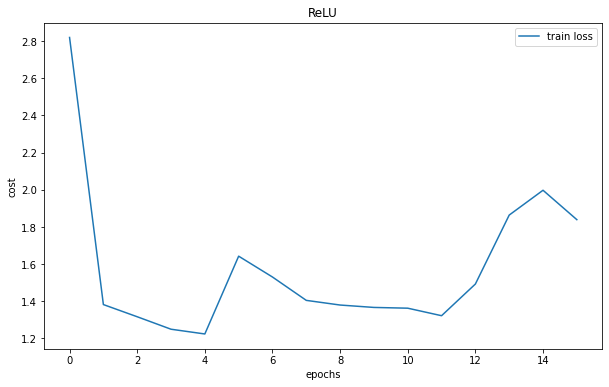

In [27]:
plt.figure(figsize=(10,6))
plt.plot(mlpc.loss_curve_, label='train loss')
plt.title('ReLU')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

In [18]:
mlpc = MLPClassifier(random_state=0, activation='logistic', max_iter=150, hidden_layer_sizes=[256, 128, 64, 32], learning_rate_init=0.08).fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.10214285714285715

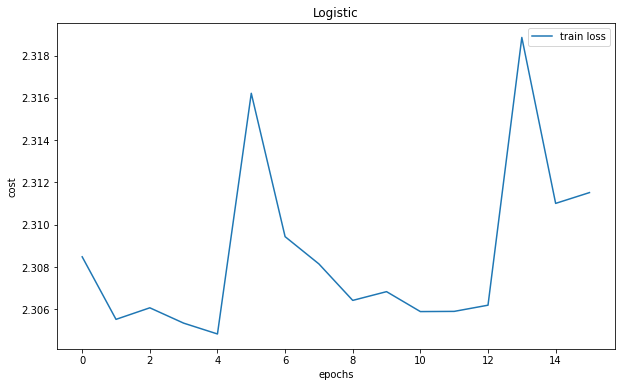

In [20]:
plt.figure(figsize=(10,6))
plt.plot(mlpc.loss_curve_, label='train loss')
plt.title('Logistic')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

In [21]:
mlpc = MLPClassifier(random_state=0, activation='tanh', max_iter=150, hidden_layer_sizes=[256, 128, 64, 32], learning_rate_init=0.08).fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.10571428571428572

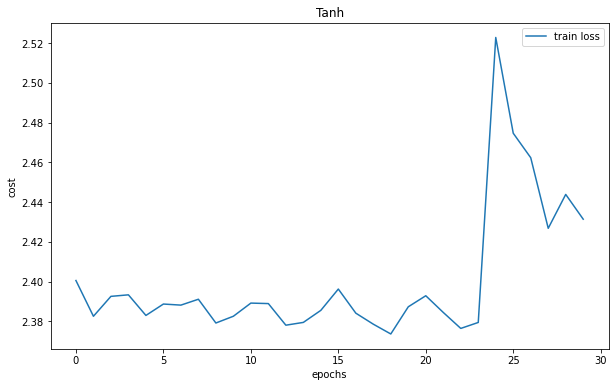

In [22]:
plt.figure(figsize=(10,6))
plt.plot(mlpc.loss_curve_, label='train loss')
plt.title('Tanh')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

In [23]:
mlpc = MLPClassifier(random_state=0, activation='identity', max_iter=150, hidden_layer_sizes=[256, 128, 64, 32], learning_rate_init=0.08).fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.88

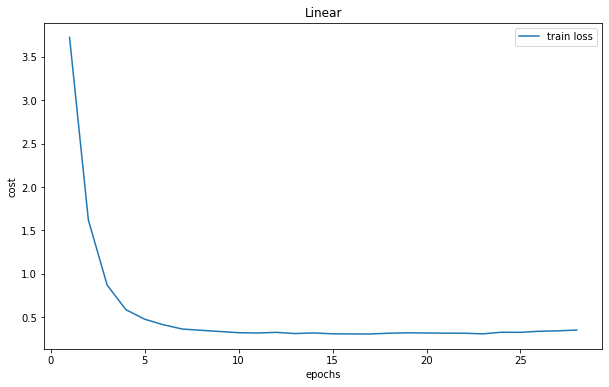

In [24]:
plt.figure(figsize=(10,6))
plt.plot(mlpc.loss_curve_, label='train loss')
plt.title('Linear')
plt.xlabel('epochs')
plt.ylabel('cost')
plt.legend()
plt.show()

**Default Parameters**

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=0, activation='relu').fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.9741666666666666

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=0, activation='logistic').fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.966

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=0, activation='tanh').fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.9595

In [ ]:
from sklearn.neural_network import MLPClassifier
mlpc = MLPClassifier(random_state=0, activation='identity').fit(x_train, y_train.ravel())
mlpc.predict_proba(x_test)
mlpc.predict(x_test)
mlpc.score(x_test, y_test)

0.8526666666666667